In [ ]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import get_data_params, get_net_params 
from datasets import load_dataset

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 14})
plt.show()

np.set_printoptions(suppress=True)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

# Load in datasets

In [ ]:
data_params = get_data_params("mnist_basic")

x_train, y_train, x_val, y_val, x_test, y_test = load_dataset("california_housing", data_params, verbose=True)

In [ ]:
print("="*50)
print("  Running Unit Tests for the load_dataset Function  ")
print("="*50)

# List of datasets the function is supposed to handle, plus an invalid one
datasets_to_test = ["mnist", "cifar10", "imdb", "california_housing", "unknown_dataset"]
failed_tests = []
successful_tests = []

for name in datasets_to_test:
    print(f"\n>>> Testing dataset: '{name}'...")
    try:
        # Call the function and suppress its verbose output for cleaner test logs
        x_train, y_train, x_val, y_val, x_test, y_test = load_dataset(
            dataset_name=name, 
            params=None, 
            verbose=True
        )

        # Add a check to ensure the validation split isn't empty, a common slicing error
        if x_val.shape[0] == 0:
            raise ValueError("Validation split resulted in an empty array. Check slicing logic.")

        print(f"[SUCCESS] '{name}' loaded and passed all assertions.")
        successful_tests.append(name)

    except Exception as e:
        print(f"[ERROR]: '{name}' encountered an error.")
        print(f"   Error Type:    {type(e).__name__}")
        print(f"   Error Details: {e}")
        failed_tests.append(name)

# --- Final Summary ---
print("\n" + "="*50)
print("                  TEST SUMMARY")
print("="*50)
print(f"Successful tests ({len(successful_tests)}): {', '.join(successful_tests) if successful_tests else 'None'}")
print(f"Failed tests ({len(failed_tests)}): {', '.join(failed_tests) if failed_tests else 'None'}")
print("="*50)

if failed_tests:
    print("\nReview the 'ERROR' sections above to debug your function.")

# Build network

In [ ]:
net_name = "base_cnn"
net_params = get_net_params(net_name)

inputs = tf.keras.Input(shape=net_params["input_shape"])
x = inputs

for layer in net_params["conv_layers"]:
    x = tf.keras.layers.Conv2D(
        filters=layer["filters"],
        kernel_size=layer["kernel_size"],
        activation=None,
        padding="same"
    )(x)
    if layer.get("batch_norm", False):
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(layer["activation"])(x)
    if layer.get("max_pool", False):
        x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x)

# Dense Layers
for layer in net_params["dense_layers"]:
    x = tf.keras.layers.Dense(layer["units"], activation=layer["activation"])(x)
    if "dropout_rate" in layer:
        x = tf.keras.layers.Dropout(layer["dropout_rate"])(x)

# Output Layer
outputs = tf.keras.layers.Dense(net_params["num_classes"], activation=net_params["output_layer"]["activation"])(x)

model = tf.keras.Model(inputs, outputs, name=net_name)


In [ ]:
opt_config = net_params["optimizer"]
optimizer = getattr(tf.optimizers, opt_config["type"].capitalize())(learning_rate=opt_config["learning_rate"])

model.compile(
    optimizer=optimizer,
    loss=net_params["loss"],
    metrics=net_params["metrics"]
)

model.summary()

st = time.time()
# Train
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val) if x_val is not None else None,
    epochs=net_params["epochs"],
    batch_size=net_params["batch_size"],
    shuffle=data_params.get("shuffle", True)
)
training_duration_seconds = time.time() - st

In [ ]:
from utils import analyze_history

analyze_history(history)

In [ ]:
from utils import save_model_wts

save_model_wts(model=model, data_name="mnist", history= history, training_duration_seconds=training_duration_seconds)

In [ ]:
from utils import load_json_results

results = load_json_results(name="base_cnn_mnist_2025-08-07_11-50", print_results=True)

# CNN Class tests

In [ ]:
import tensorflow as tf

from base_networks import CNN, MLP
from datasets import load_dataset
from utils import get_net_params, get_data_params, analyze_history, load_json_results

In [ ]:
base_cnn_params = get_net_params("base_cnn")
# reg_cnn_params = get_net_params("base_mlp")
data_params = get_data_params("cifar10_basic")
# reg_data_params = get_data_params("california_housing_basic")

cifar_data = load_dataset("cifar10", data_params, verbose=True)
# california_data = load_dataset("california_housing", reg_data_params, verbose=True)

# --- Build the SINGLE-OUTPUT Classification Model ---
print("\n---- BUILDING CLASSIFICATION MODEL ----")
mnist_model_wrapper = CNN(params=base_cnn_params)
mnist_model = mnist_model_wrapper.build_model(data_params=data_params, print_summary=False)
mnist_model_wrapper.compile_model()

history = mnist_model_wrapper.fit_model(x_train=cifar_data[0], y_train=cifar_data[1], 
                                        x_val=cifar_data[2], y_val=cifar_data[3], 
                                        save_wts=True, verbose=True)
# --- Build the MULTI-OUTPUT Regression Model ---
# print("\n\n---- BUILDING REGRESSION MODEL ----")
# property_model_wrapper = MLP(net_params=reg_cnn_params)
# property_model = property_model_wrapper.build_model(data_params=reg_data_params, print_summary=True)
# property_model_wrapper.compile_model()

In [ ]:
analyze_history(history)
results = load_json_results(name="functional-cifar10_2025-08-07_16-47", print_results=True)

# Test Multiple Networks

In [ ]:
import tensorflow as tf

from base_networks import CNN
from datasets import load_dataset
from utils import get_net_params, get_data_params, analyze_history, load_json_results

In [ ]:
networks = ["cnn_1", "cnn_2"]
dataset = "mnist"

hist_objs = []
for network in networks:
    net_params = get_net_params(network)
    
    data_params = get_data_params(dataset)
    data = load_dataset(dataset, data_params, verbose=True)
    
    model = CNN(params=net_params)
    model.build_model(data_params=data_params, print_summary=False)
    model.compile_model()
    
    history = model.fit_model(x_train=data[0], y_train=data[1], 
                              x_val=data[2], y_val=data[3], 
                              save_wts=True, verbose=True)
    hist_objs.append(history)

In [ ]:
from run_networks import run_experiments

networks = ["cnn_1", "cnn_2"]
hists = run_experiments(networks_list=networks, data_set_name="mnist", save_wts=True, verbose=True)

# Visualize Conv Neuron Activations

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from base_networks import CNN
from datasets import load_dataset
from utils import get_net_params, get_data_params

2025-08-11 16:25:11.541773: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 16:25:11.552909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754943911.567347   39071 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754943911.570900   39071 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754943911.580306   39071 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
base_cnn_params = get_net_params("cnn_2")
data_params = get_data_params("mnist")

mnist_data = load_dataset("mnist", data_params, verbose=True)

# --- Build the SINGLE-OUTPUT Classification Model ---
print("\n---- BUILDING CLASSIFICATION MODEL ----")
model = CNN(params=base_cnn_params)
model.build_model(data_params=data_params, print_summary=False)
model.compile_model()

history, ttt = model.fit_model(x_train=mnist_data[0], y_train=mnist_data[1], 
                                        x_val=mnist_data[2], y_val=mnist_data[3], 
                                        save_wts=True, verbose=True)

[NOTICE] Using MNIST dataset from TensorFlow Datasets, params file will be ignored.

             DATASET SHAPES             
Training Data (x):       (50000, 28, 28)
Training Labels (y):     (50000,)
----------------------------------------
Validation Data (x):     (10000, 28, 28)
Validation Labels (y):   (10000,)
----------------------------------------
Test Data (x):           (10000, 28, 28)
Test Labels (y):         (10000,)


---- BUILDING CLASSIFICATION MODEL ----
Initialized model 'base_cnn_2'.
Building single-output classification head...
Model compiled successfully.


2025-08-11 16:25:13.857310: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "base_cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,442,762 (24.58 MB)

 Trainable params: 6,442,762 (24.58 MB)

 Non-trainable params: 0 (0.00 B)

Configured early_stopping with params: {'monitor': 'val_loss', 'patience': 10, 'restore_best_weights': True}
Configured model_checkpoint with params: {'filepath': 'checkpoints/model_{epoch:02d}.weights.h5', 'monitor': 'val_loss', 'save_best_only': True, 'save_weights_only': True}
Configured reduce_lr_on_plateau with params: {'monitor': 'val_loss', 'factor': 0.1, 'patience': 5, 'min_lr': 1e-05}
Epoch 1/500
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.9127 - loss: 1.6442 - val_accuracy: 0.9766 - val_loss: 0.0776 - learning_rate: 0.0010
Epoch 2/500
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.9755 - loss: 0.0794 - val_accuracy: 0.9815 - val_loss: 0.0656 - learning_rate: 0.0010
Epoch 3/500
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9836 - loss: 0.0524 - val_accuracy: 0.9809 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 4/500
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9887 - loss: 0.0353 - val_accuracy: 0.9816 - val_loss: 0.0779 - learn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/home/mkpuzon/code/Neural-Nets-Library/base_networks.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


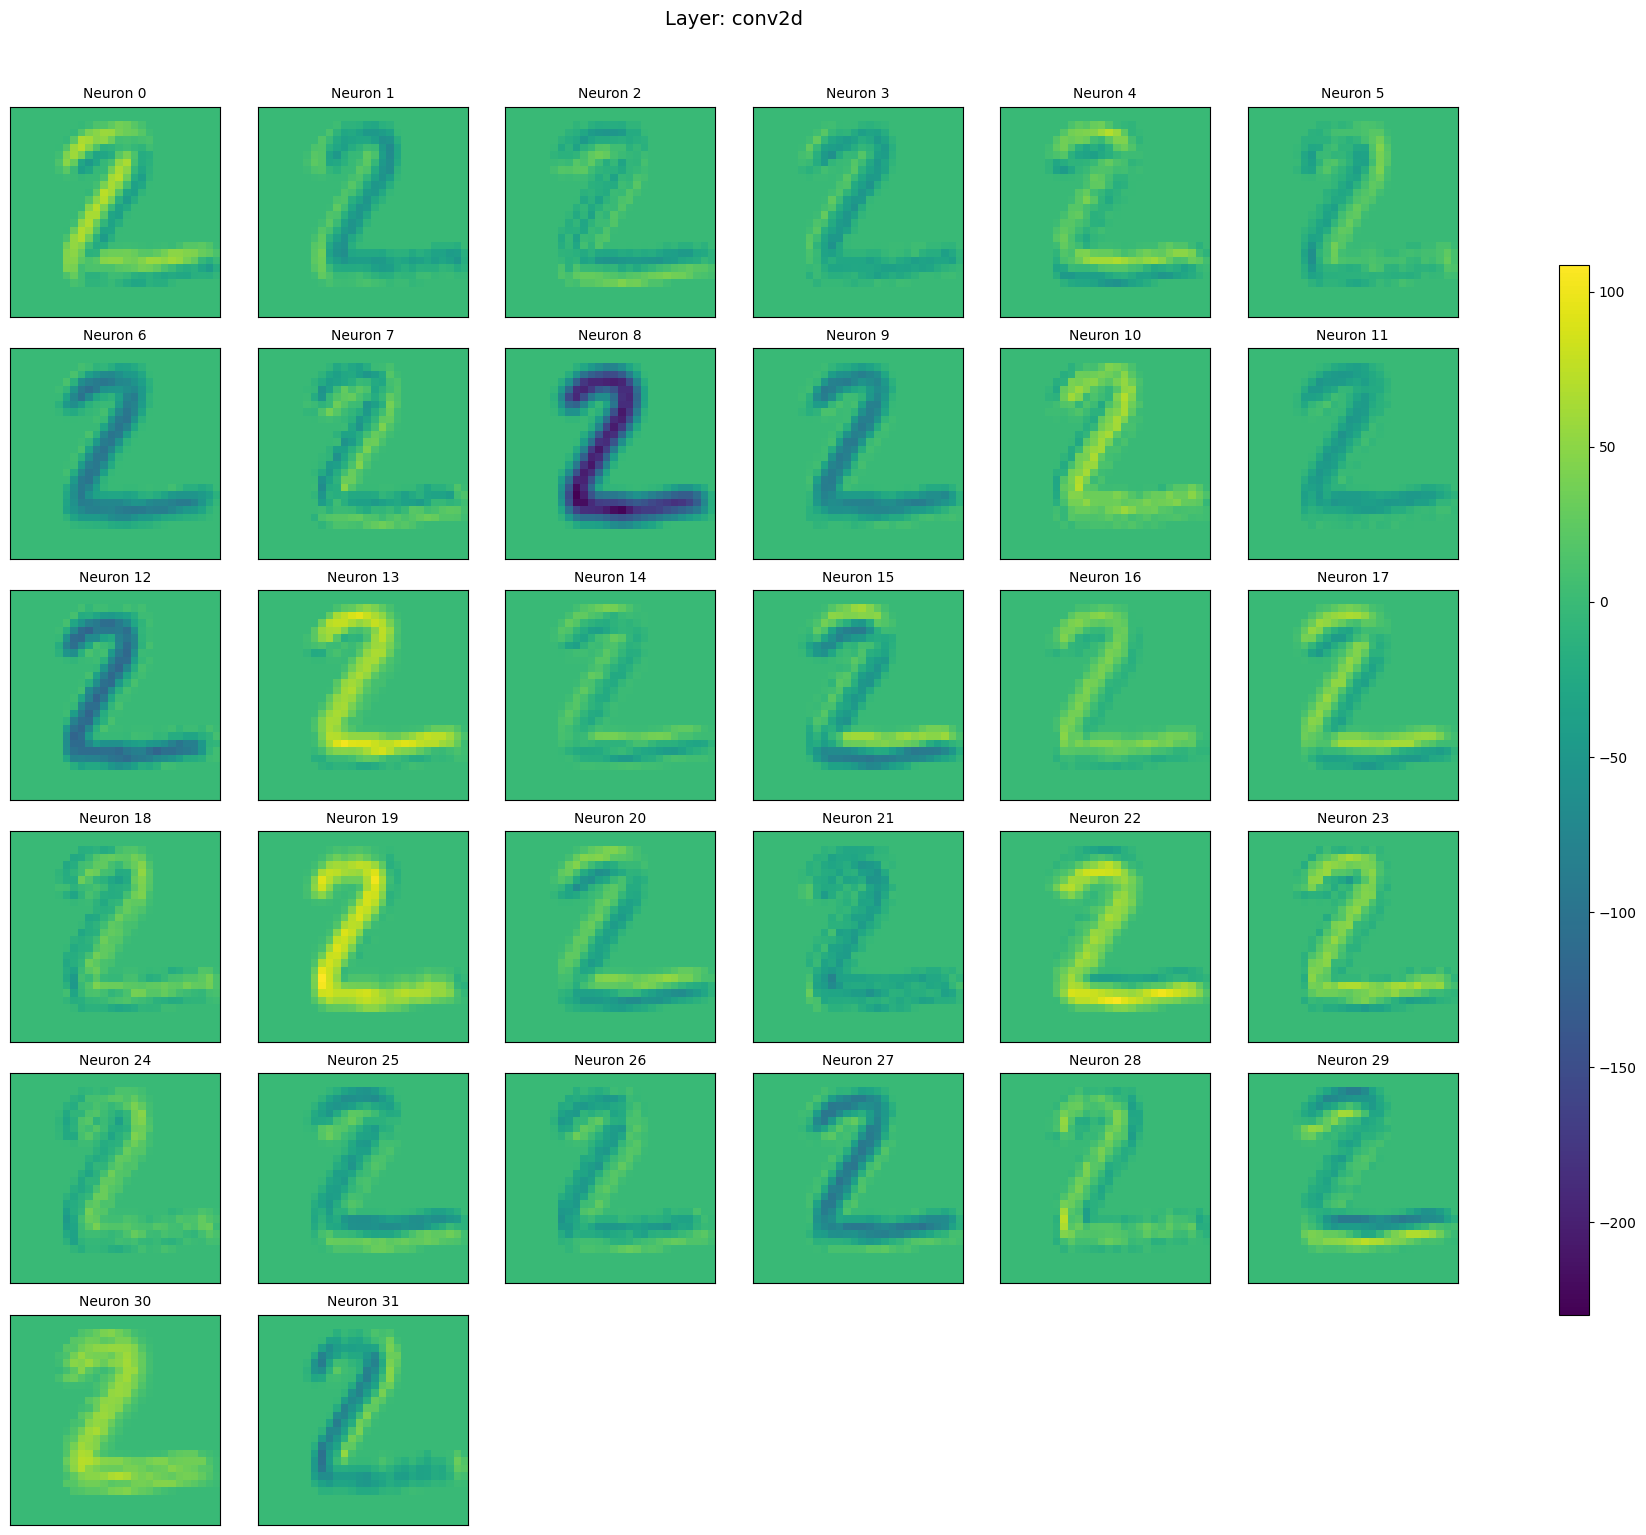

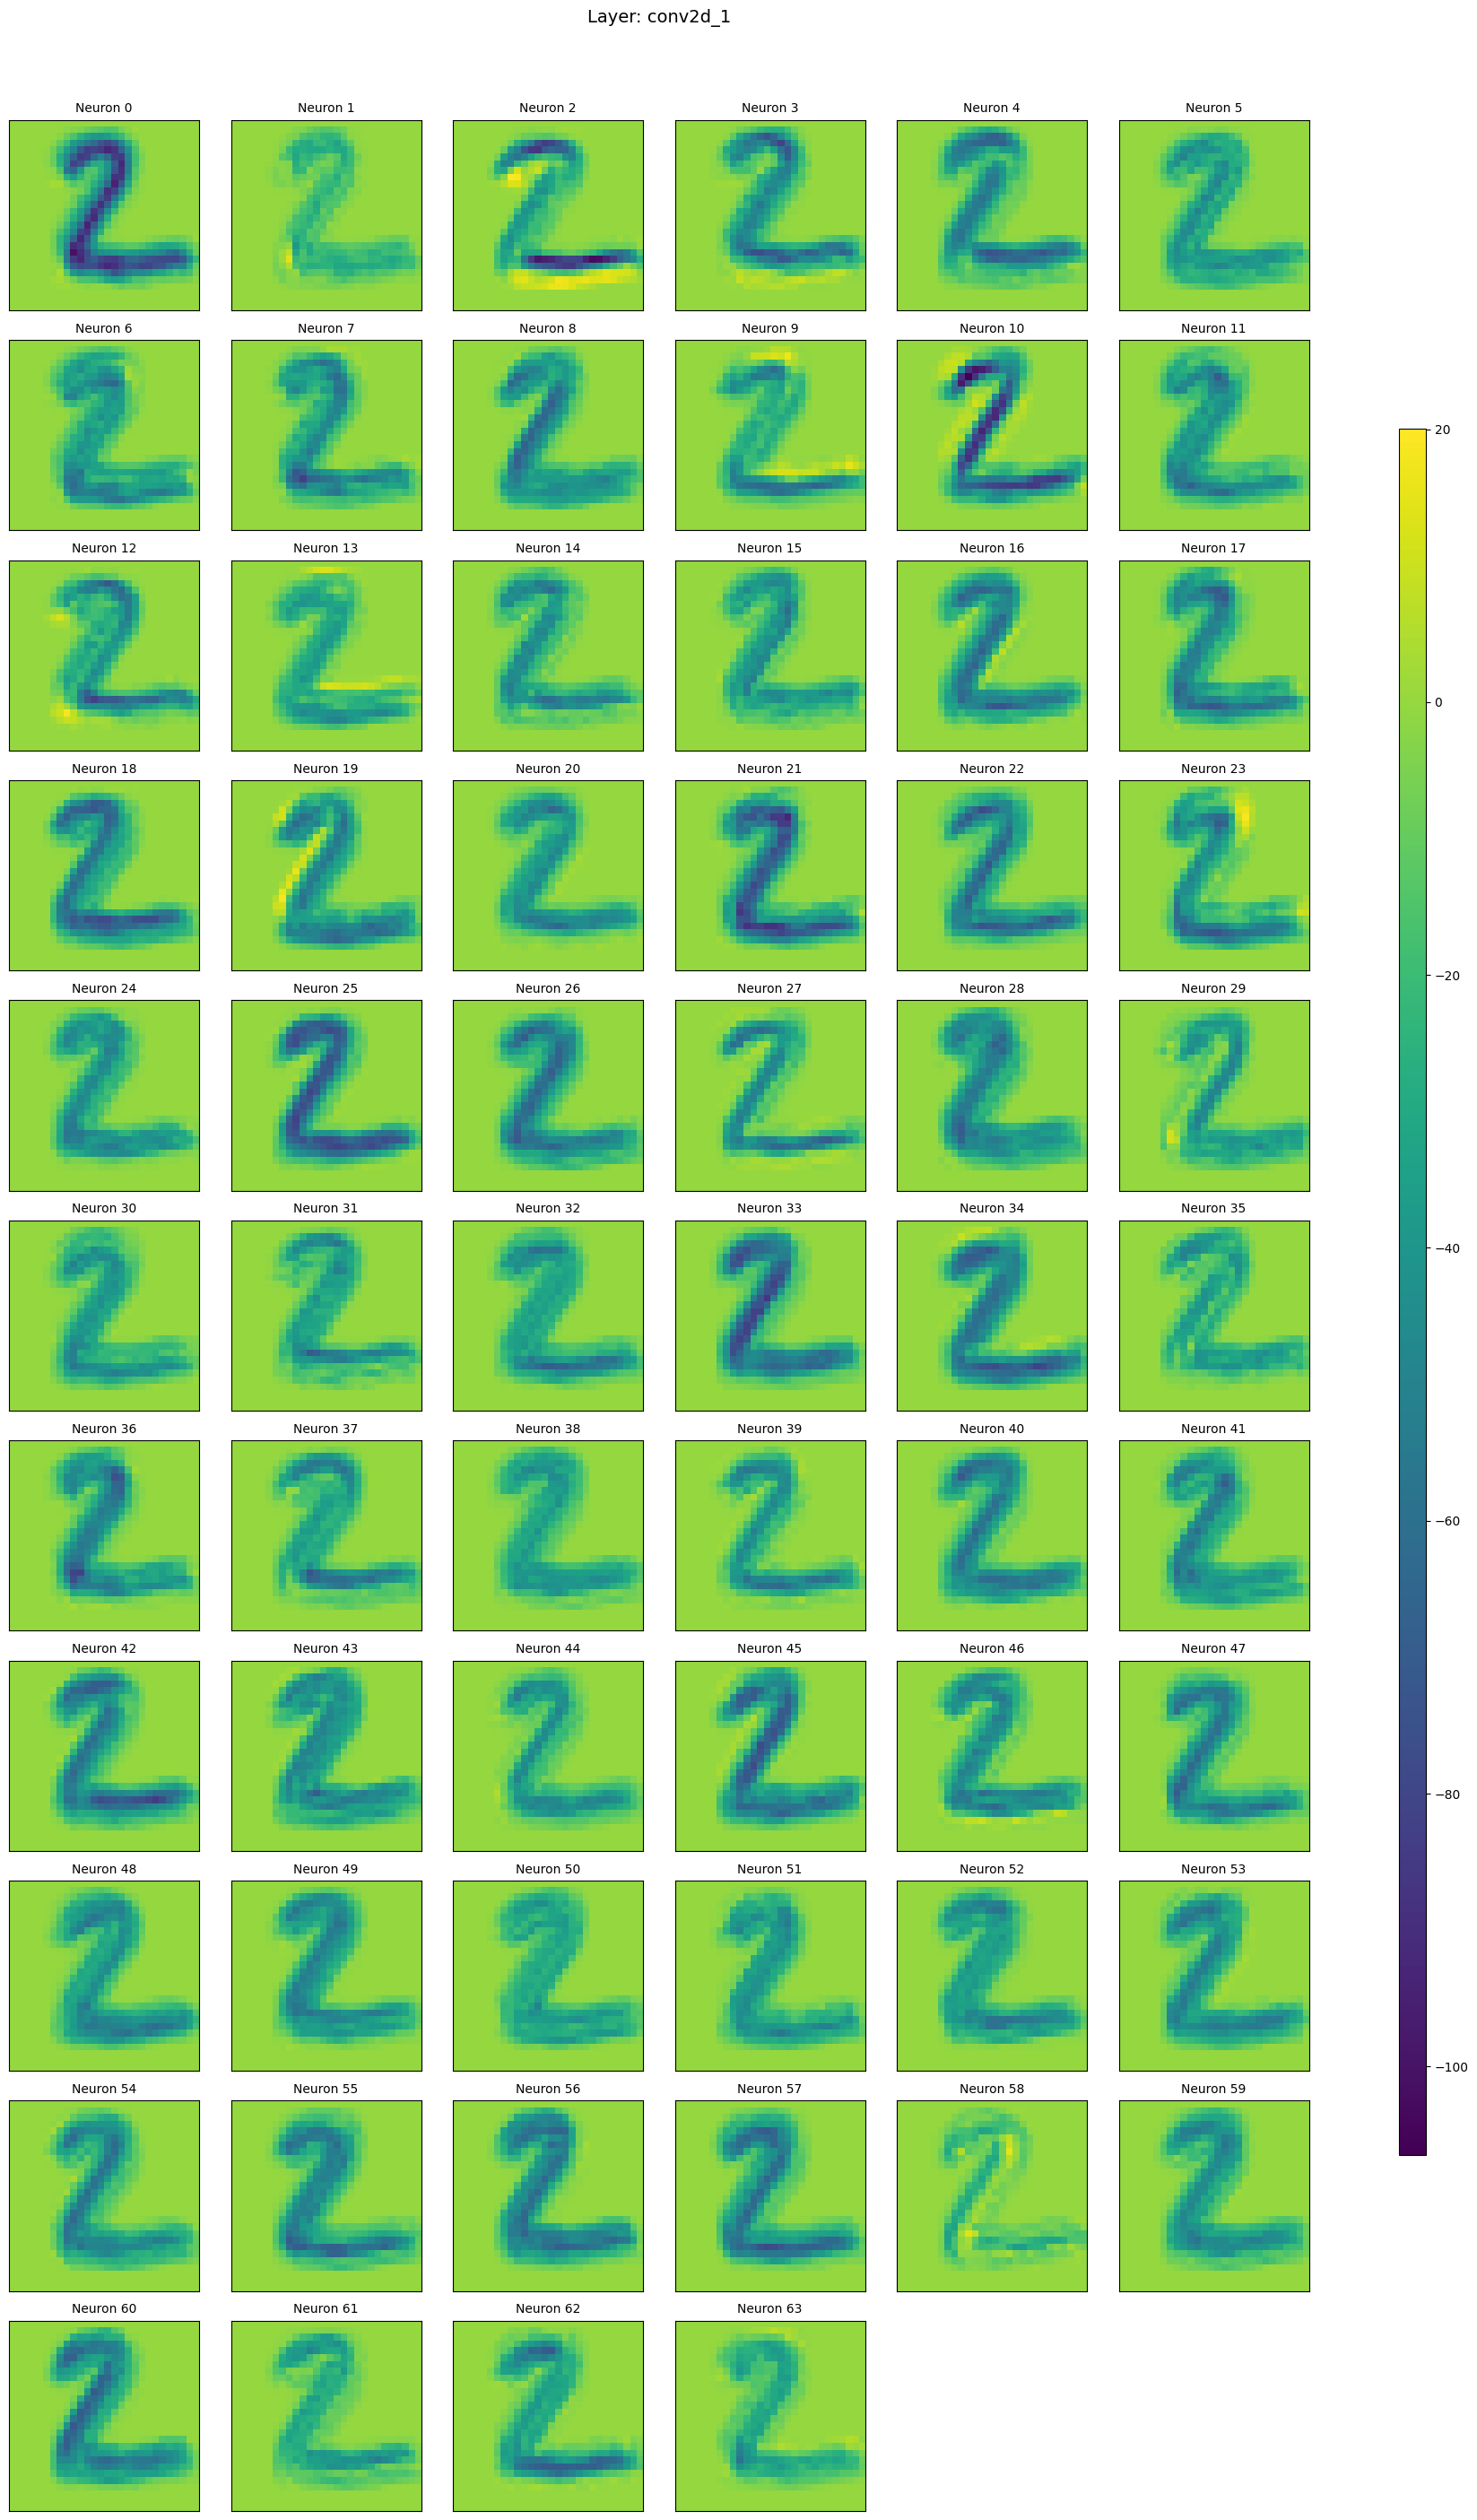

In [3]:
model.visualize_conv_layers(test_data=mnist_data[-2], index=1, match_str='conv2d', neurons=None)

In [4]:
# saving model
model.save_full(data_name="mnist", history=history, training_duration_seconds=ttt)

Model stored in directory: training_runs/base_cnn_2-mnist_2025-08-11_16-32
Saved model weights to: training_runs/base_cnn_2-mnist_2025-08-11_16-32/base_cnn_2.weights.h5
Saved training metadata to: training_runs/base_cnn_2-mnist_2025-08-11_16-32/metadata.yaml
